# 🌲 Random Forest Models for Drug Sensitivity Prediction

This notebook trains a **Random Forest (RF)** regression model per drug using gene expression features (PCA or HVGs). RFs are robust, handle nonlinearities, and offer good interpretability with minimal hyperparameter tuning. We use **5-fold cross-validation** to evaluate each model’s performance with RMSE and R² metrics.



In [4]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
NUM_PCS = 20

# Choose your dataset (PCA or HVG)
DATA_PATH = "../../../data/bulk/bulk_with_pca.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 23)


### 🔁 Train One Random Forest Per Drug

For each drug, we train a separate RF model using its associated (cell line, IC50, features) data. We use train-test split and evaluate with RMSE and R².


In [6]:
os.makedirs("rf/models", exist_ok=True)
os.makedirs("rf/results", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        print(f"⚠️ Skipped drug {drug_id} (samples: {df.shape[0]})")
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )

    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    print(f"\n🌲 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ RMSE (folds): {(-rmse_scores).round(4)} | Mean: {-rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"  ➤ R²   (folds): {r2_scores.round(4)} | Mean: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })

    model.fit(X, y)
    joblib.dump(model, f"rf/models/rf_drug_{drug_id}.pkl")



🌲 Drug 1 | Samples: 391
  ➤ RMSE (folds): [1.4211 0.9792 0.8996 1.2794 1.1198] | Mean: 1.1398 ± 0.1911
  ➤ R²   (folds): [-0.3775 -0.0328 -0.1761  0.0696  0.0594] | Mean: -0.0915 ± 0.1680

🌲 Drug 3 | Samples: 356
  ➤ RMSE (folds): [2.2744 1.7173 2.1198 1.797  2.1181] | Mean: 2.0053 ± 0.2119
  ➤ R²   (folds): [-0.0951  0.0659  0.0157 -0.11    0.0166] | Mean: -0.0214 ± 0.0689

🌲 Drug 5 | Samples: 394
  ➤ RMSE (folds): [1.4762 1.4084 1.6181 1.5244 1.4677] | Mean: 1.4989 ± 0.0700
  ➤ R²   (folds): [0.1998 0.1217 0.1043 0.2243 0.1944] | Mean: 0.1689 ± 0.0471

🌲 Drug 6 | Samples: 403
  ➤ RMSE (folds): [0.9043 1.1116 0.8726 0.8319 0.8831] | Mean: 0.9207 ± 0.0983
  ➤ R²   (folds): [-0.1204 -0.1768  0.0097 -0.073  -0.0514] | Mean: -0.0824 ± 0.0631

🌲 Drug 9 | Samples: 396
  ➤ RMSE (folds): [1.4537 1.3022 1.1811 1.6085 1.4607] | Mean: 1.4013 ± 0.1466
  ➤ R²   (folds): [ 0.0367  0.1009  0.2084 -0.0448  0.0471] | Mean: 0.0696 ± 0.0836

🌲 Drug 11 | Samples: 393
  ➤ RMSE (folds): [2.0777 1.9712 1.8

In [7]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"rf/results/model_performance_summary_{NUM_PCS}_pcs.csv", index=False)

print("📁 Saved to rf/results/model_performance_summary.csv")
results_df.head()


📁 Saved to rf/results/model_performance_summary.csv


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,1.139835,0.191064,-0.091479,0.167996
1,3,356,2.005319,0.211948,-0.021388,0.068905
2,5,394,1.498939,0.070048,0.168901,0.047086
3,6,403,0.920702,0.098295,-0.082390,0.063050
4,9,396,1.401261,0.146641,0.069644,0.083584


### 📊 Distribution of RF Model Performance
We now visualize the RMSE and R² scores to analyze how well the RF models performed across all drugs.


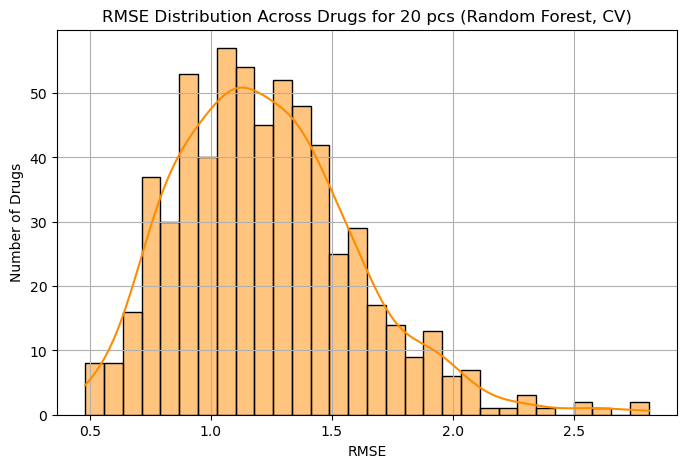

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title(f"RMSE Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"rf/results/rmse_comparison_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()

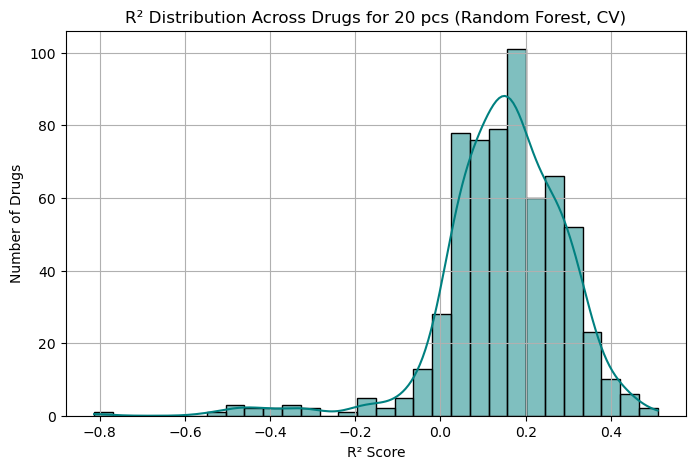

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title(f"R² Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"rf/results/r2_comparison_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()